# Detection of Pneumonia from Chest X-Rays

## Importing the necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from mlxtend.plotting import plot_confusion_matrix

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

## Importing and loading the dataset

### Description of the Pneumonia Dataset

The dataset is organized into **3 folders (train, test, val)** and contains subfolders for each image category **(Pneumonia/Normal)**. 
There are **5,863** X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

1) train= contains the training data/images for teaching our model.

2) val= contains images which we will use to validate our model. The purpose of this data set is to prevent our model from Overfitting.
Overfitting or high variance in machine learning models occurs when the accuracy of your training dataset, the dataset used to “teach” the model, is greater than your testing accuracy. In terms of ‘loss’, overfitting reveals itself when your model has a low error in the training set and a higher error in the testing set.

The validation set should be used to fine-tune your model until you’re satisfied with its performance, then switch to the testing data to train the best version of your model. 

3) test = this contains the data that we use to test the model once it has learned the relationships between the images and their label (Pneumonia/Not-Pneumonia)

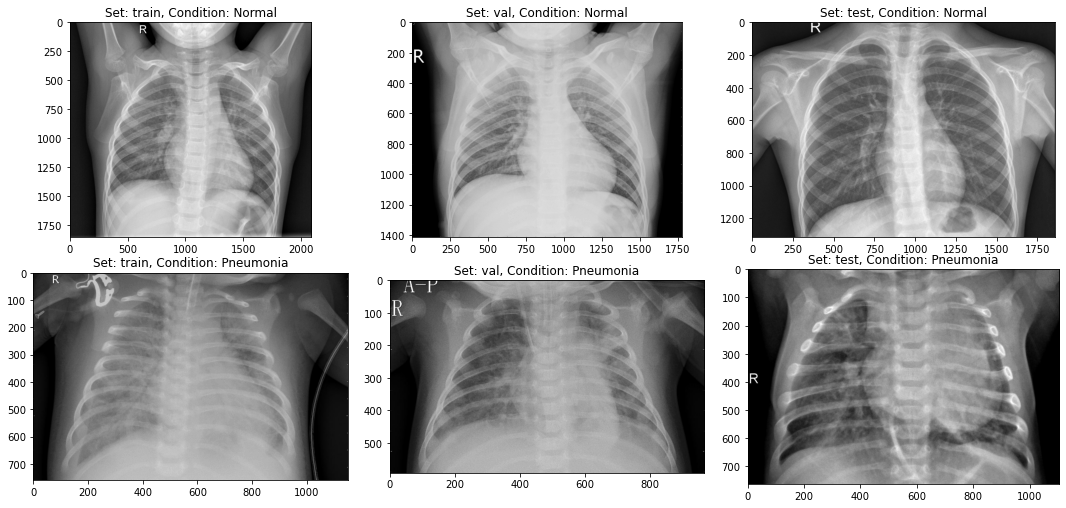

In [2]:
input_path = 'C:/Users/Lenovo/Downloads/Artificial Intelligence (CSE 3013)/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [3]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1349, pneumonia images: 3883
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


## Data Visualization and Interpretation

In [4]:
train_data=[]

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'train' + cond)):
        if cond=='/NORMAL/':
            label = 0
        elif cond=='/PNEUMONIA/':
            label = 1
        train_data.append([img, label])


<AxesSubplot:ylabel='count'>

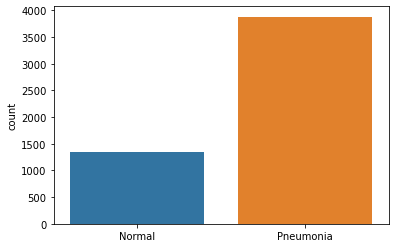

In [5]:
import seaborn as sns
train = []
for i in train_data:
    if(i[1] == 0):
        train.append("Normal")
    else:
        train.append("Pneumonia")
sns.countplot(x=train)

#### The data seems imbalanced . To increase the no. of examples, I will use data augmentation

# Data Augmentation

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

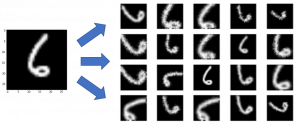

In [6]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [7]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## CONVOLUTIONAL NEURAL NETWORKS 

A Convolutional Neural Network is a special type of an Artificial Intelligence implementation which uses a special mathematical matrix manipulation called the convolution operation to process data from the images.

- A convolution does this by multiplying two matrices and yielding a third, smaller matrix.

- The Network takes an input image, and uses a filter (or kernel) to create a feature map describing the image.

- In the convolution operation, we take a filter (usually 2x2 or 3x3 matrix ) and slide it over the image matrix. The coresponding numbers in both matrices are multiplied and and added to yield a single number describing that input space. This process is repeated all over the image.This can be seen in the following animation

- We use different filters to pass over our inputs, and take all the feature maps, put them together as the final output of the convolutional layer.

- We then pass the output of this layer through a non-linear activation function. The most commonly used one is ReLU.

- The next step of our process involves further reducing the dimensionality of the data which will lower the computation power required for training this model. This is achieved by using a Pooling Layer. The most commonly used one is max pooling which takes the maximum value in the window created by a filter. This significantly reduces the training time and preserves significant information

## Training the Model

#### The next step was to build the model. This can be described in the following 5 steps:

1) I used five convolutional blocks comprised of convolutional layer, max-pooling and batch-normalization.

2) On top of it I used a flatten layer and followed it by four fully connected layers.

3) Also in between I have used dropouts to reduce over-fitting.

4) Activation function was Relu throughout except for the last layer where it was Sigmoid as this is a binary classification problem.

5) I have used Adam as the optimizer and cross-entropy as the loss.

Before training the model is useful to define one or more callbacks. Pretty handy one, are: **ModelCheckpoint and EarlyStopping**.

**ModelCheckpoint:** when training requires a lot of time to achieve a good result, often many iterations are required. In this case, it is better to save a copy of the best performing model only when an epoch that improves the metrics ends.

**EarlyStopping:** sometimes, during training we can notice that the generalization gap (i.e. the difference between training and validation error) starts to increase, instead of decreasing. This is a symptom of overfitting that can be solved in many ways (reducing model capacity, increasing training data, data augumentation, regularization, dropout, etc). Often a practical and efficient solution is to stop training when the generalization gap is getting worse.

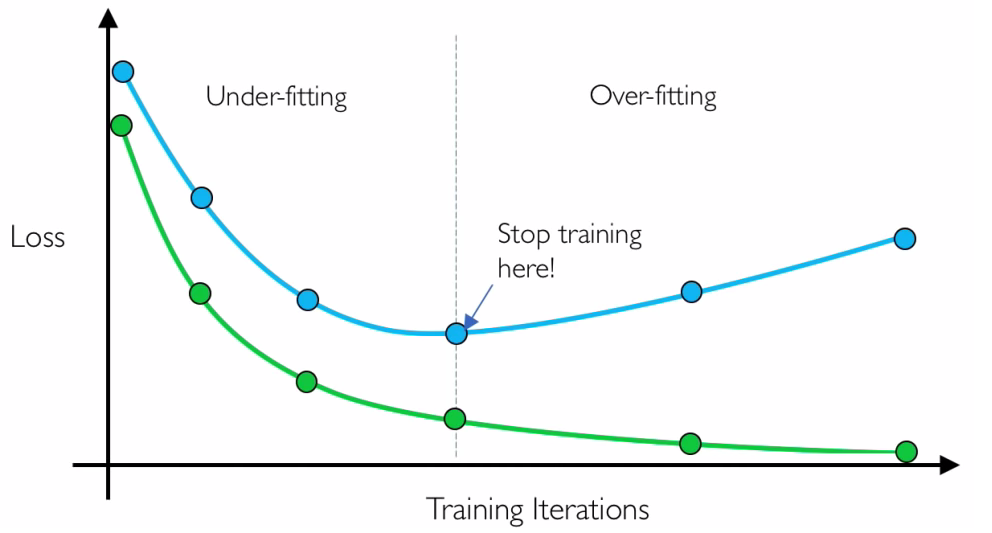

In [8]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)       

In [9]:
hist = model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/10
163/163 [==============================] - 392s 2s/step - loss: 0.3616 - accuracy: 0.8365 - val_loss: 0.7084 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 337s 2s/step - loss: 0.2980 - accuracy: 0.8775 - val_loss: 1.8480 - val_accuracy: 0.6234
Epoch 3/10
163/163 [==============================] - 348s 2s/step - loss: 0.2576 - accuracy: 0.8950 - val_loss: 2.0149 - val_accuracy: 0.6283
Epoch 4/10
163/163 [==============================] - 438s 3s/step - loss: 0.2233 - accuracy: 0.9156 - val_loss: 1.2120 - val_accuracy: 0.6250
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.9212
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 431s 3s/step - loss: 0.2085 - accuracy: 0.9212 - val_loss: 0.4064 - val_accuracy: 0.7944
Epoch 6/10
163/163 [==============================] - 397s 2s/step - loss: 0.1858 - accuracy: 0.9337 - val_loss: 0.2657 

## Analysis after Model Training

### Let’s visualize the loss and accuracy plots.

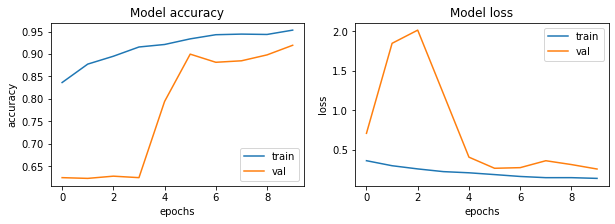

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### So far good. The model is converging which can be observed from the decrease in loss and validation loss with epochs. Also it is able to reach 90% validation accuracy in just 10 epochs.

# Testing and Prediction 

## Confusion matrix

Confusion matrix is an important tool to evaluate our classifier performance. It provides us a clear picture of the performance of our classifier. It creates a matrix where we can find the frequency of hits and misses of each labels. To compute the confusion matrix, you need to have a set of predictions, so they can be compared to actual targets.

**True Positive:**
Interpretation: You predicted positive and it’s true.

**True Negative:**
Interpretation: You predicted negative and it’s true.

**False Positive: (Type 1 Error)**
Interpretation: You predicted positive and it’s false.

**False Negative: (Type 2 Error)**
Interpretation: You predicted negative and it’s false.

---------------------- CONFUSION MATRIX ----------------------


Text(0.5, 15.0, 'Predicted label')

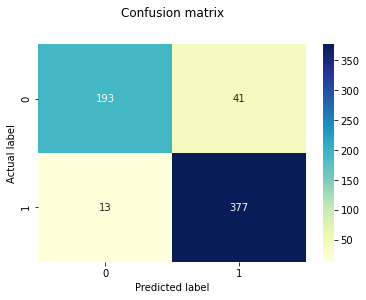

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

accuracy = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('---------------------- CONFUSION MATRIX ----------------------')

p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Various Prediction Metrices

Precision, Recall and F1-Score can be calculated as fellow:

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

F1-Score = 2 ( Precision * Recall)/(Precision + Recall)

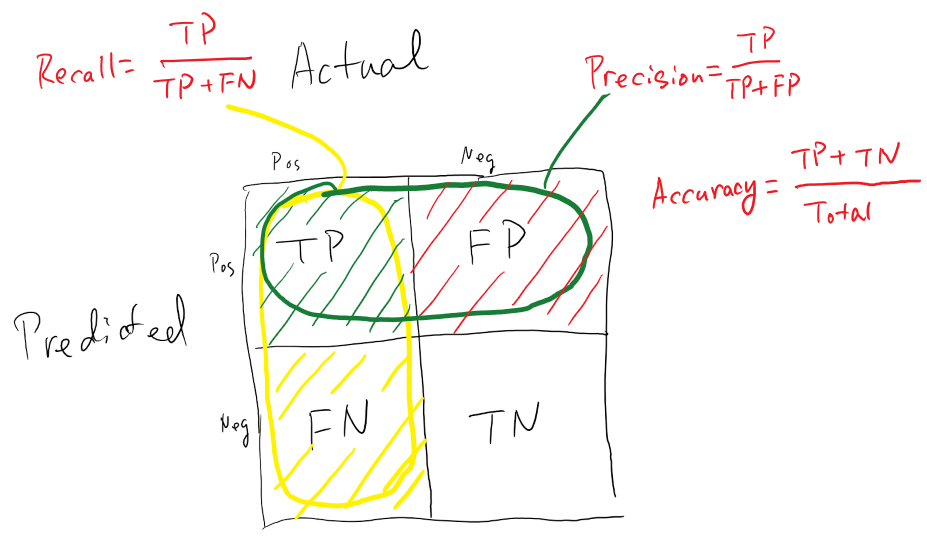

In [14]:
print('\n---------------------- TRAIN METRIC ----------------------')
print('Train accuracy: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

print('\n---------------------- TEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(accuracy))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))


---------------------- TRAIN METRIC ----------------------
Train accuracy: 95.31

---------------------- TEST METRICS ----------------------
Accuracy: 91.34615384615384%
Precision: 90.19138755980862%
Recall: 96.66666666666667%
F1-score: 93.31683168316832
